In [191]:
import sys
import os

sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import (
    RandomIntervalSDOMLDataset,
    RandomIntervalSDOMLDataModule,
)
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch

In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [26]:
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=4,
    num_workers=10,
    num_frames=2,
    blosc_cache="/home/rlx/blosc_cache",
    start_date="2010-01-01",
    end_date="2010-12-31",
    dim=False,
    sampling_period="4days",
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [322]:
dltrain = data_module.train_dataloader()

for batch in dltrain:
    print(".", end="")
    if np.random.random() < 0.01:
        break

............................................................................................................................................

In [323]:
t = batch["timestamps"]
n = len(batch["image_stack"])

tdeltas_truth = (
    torch.tensor(
        [
            (pd.Timestamp(t[1][ni]) - pd.Timestamp(t[0][ni]))
            / pd.Timedelta(data_module.sampling_period)
            for ni in range(n)
        ]
    )
    .reshape(-1, 1)
    .cuda()
)

In [372]:
channel_idx = 3
image_stack_t0 = batch["image_stack"][:, channel_idx : channel_idx + 1, 0, :, :]
image_stack_t1 = batch["image_stack"][:, channel_idx : channel_idx + 1, 1, :, :]

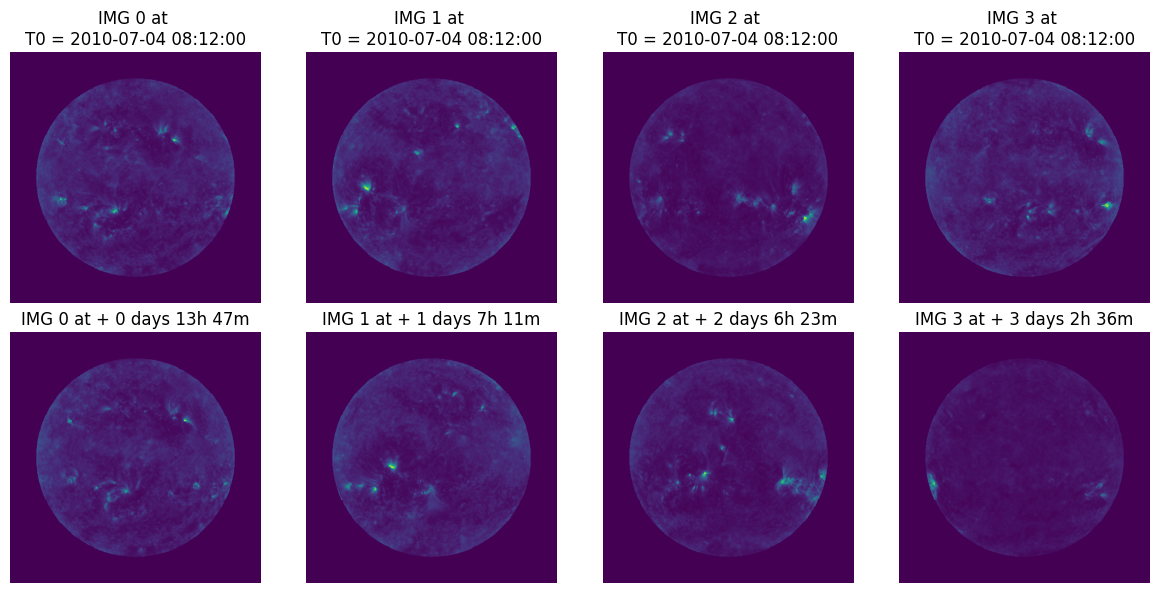

In [373]:
n = len(batch["image_stack"])
for ax, i in subplots(n * 2, n_cols=n, usizex=3, usizey=3):

    if i < n:
        xi = image_stack_t0[i][0].cpu().numpy()
        a, b = np.percentile(xi, [0, 99])
        a, b = np.percentile(xi, [0, 100])
        plt.imshow(xi, vmin=a, vmax=b)
        plt.title(f"IMG {i} at \nT0 = {batch['timestamps'][0][0]}")

    else:
        xi = image_stack_t1[i - n][0].cpu().numpy()
        a, b = np.percentile(xi, [0, 99])
        a, b = np.percentile(xi, [0, 100])
        plt.imshow(xi, vmin=a, vmax=b)

        k = tdeltas_truth[i - n, 0].cpu().numpy() * pd.Timedelta(
            data_module.sampling_period
        )
        hrs, rem = divmod(k.seconds, 3600)
        mins, secs = divmod(rem, 60)
        s = f"{k.days} days {hrs}h {mins}m"
        plt.title(f"IMG {i-n} at + {s}")
    plt.axis("off")

In [376]:
from scipy import ndimage


def norm(xi, percs=[1, 99]):
    a, b = np.percentile(xi, percs)
    xi = (xi - a) / (b - a)
    xi = (xi * 255).astype(np.uint8)
    return xi


def bright_spots(x):
    a, b = np.percentile(xi_orig, (0, 99))
    mask = x.copy()
    mask[x < b] = 0
    x = ndimage.gaussian_filter(x * mask, 7)
    t = np.percentile(xi, 90)
    x[x < t] = 0
    a, b = x.min(), x.max()
    x = (x - a) / (b - a)
    return x

In [381]:
image_stack = batch["image_stack"][:, :, 0, :, :]
image_stack.shape

torch.Size([4, 12, 512, 512])

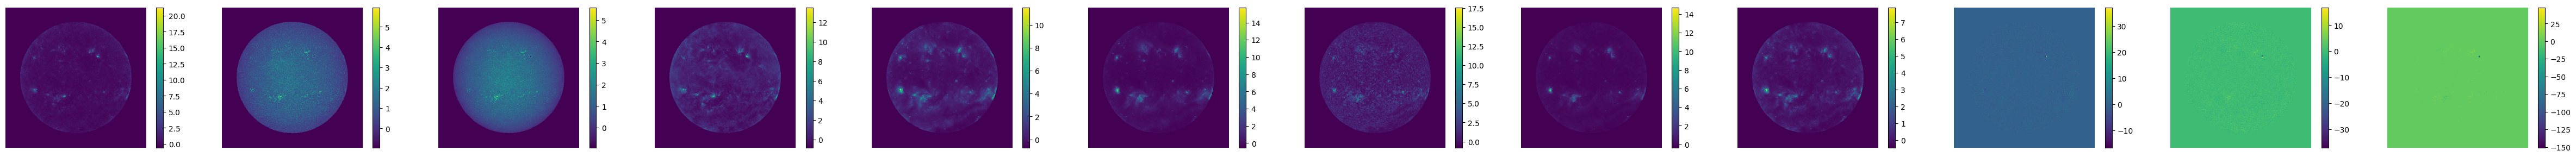

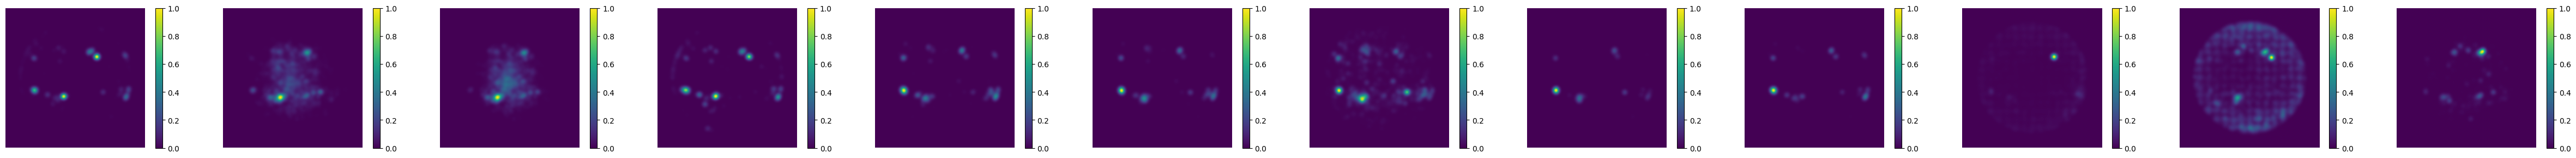

In [388]:
bi = 0
for ax, i in subplots(image_stack.shape[1], usizex=4):
    x = image_stack[bi, i].detach().numpy()
    # x = norm(x)
    plt.imshow(x)
    plt.axis("off")
    plt.colorbar()

for ax, i in subplots(image_stack.shape[1], usizex=4):
    x = image_stack[bi, i].detach().numpy()
    x = bright_spots(x)
    # x = norm(x)
    plt.imshow(x)
    plt.axis("off")
    plt.colorbar()

In [379]:
xi_orig = image_stack_t0[][0].numpy()


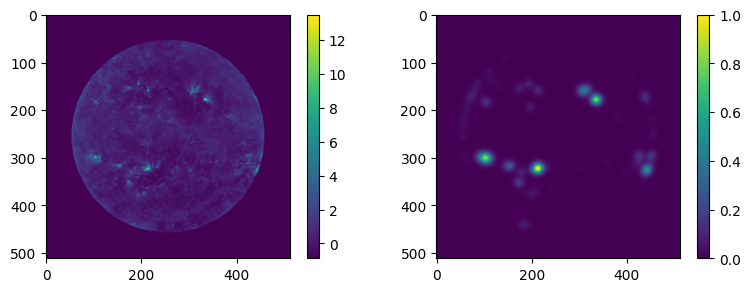

In [380]:
for ax, i in subplots(2, usizex=4):
    if i == 0:
        plt.imshow(xi_orig)
    if i == 1:
        plt.imshow(bright_spots(xi_orig))
    plt.colorbar()

2

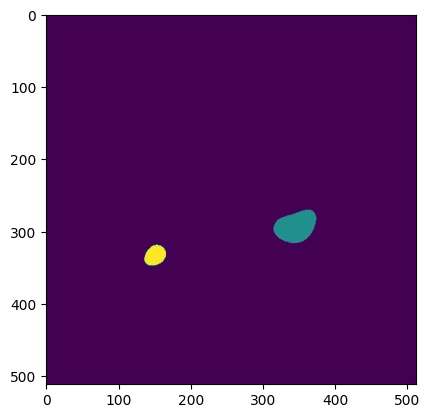

In [311]:
labels, n = ndimage.label(xi)
plt.imshow(labels)
n

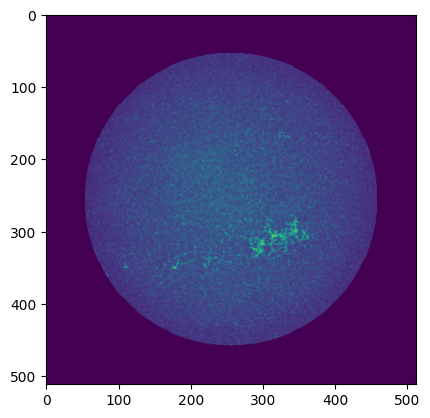

In [202]:
plt.imshow(xi)

In [45]:
import cv2
from PIL import Image

In [92]:
params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 500
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

detector = cv2.SimpleBlobDetector_create(params)

In [184]:
params.

< cv2.SimpleBlobDetector.Params 0x7f8f33c3b990>

In [189]:
def norm(xi, percs=[1, 99]):
    a, b = np.percentile(xi, percs)
    xi = (xi - a) / (b - a)
    xi = (xi * 255).astype(np.uint8)
    return xi


def plot_with_keypoints(xi):
    keypoints = detector.detect(xi)

    img_with_keypoints = cv2.drawKeypoints(
        xi,
        keypoints,
        np.array([]),
        (0, 255, 255),
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
    )
    plt.imshow(img_with_keypoints)

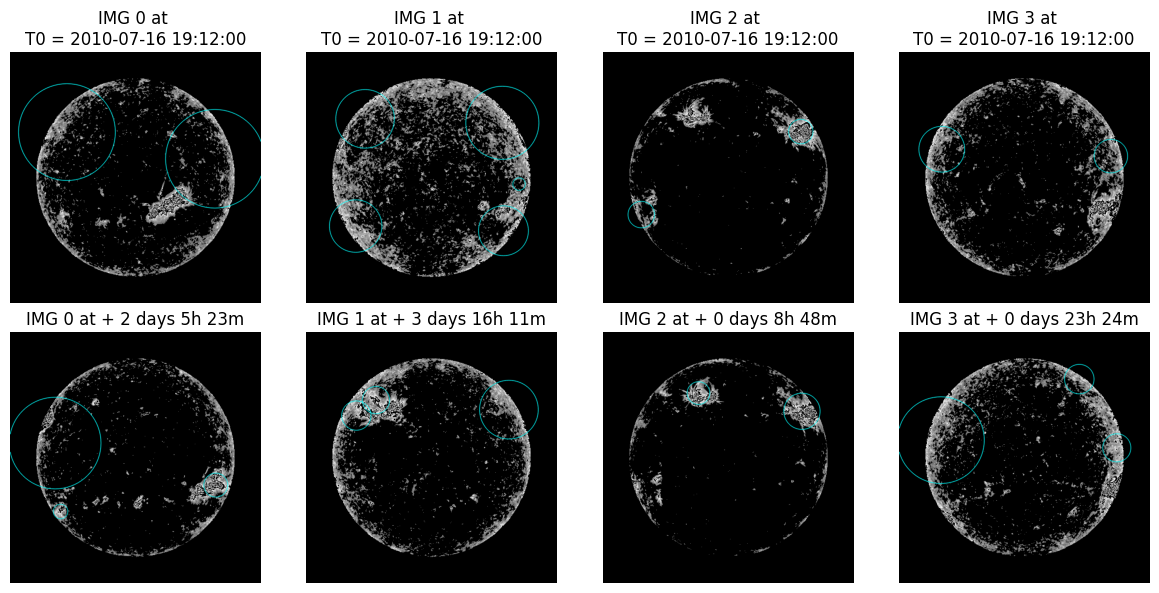

In [190]:
for ax, i in subplots(n * 2, n_cols=n, usizex=3, usizey=3):

    if i < n:
        xi = image_stack_t0[i][0].cpu().numpy()
        xi = norm(xi)
        xi[xi < 100] = 0
        plot_with_keypoints(xi)
        plt.title(f"IMG {i} at \nT0 = {batch['timestamps'][0][0]}")

    else:
        xi = image_stack_t1[i - n][0].cpu().numpy()
        xi = norm(xi)
        xi[xi < 100] = 0
        plot_with_keypoints(xi)

        k = tdeltas_truth[i - n, 0].cpu().numpy() * pd.Timedelta(
            data_module.sampling_period
        )
        hrs, rem = divmod(k.seconds, 3600)
        mins, secs = divmod(rem, 60)
        s = f"{k.days} days {hrs}h {mins}m"
        plt.title(f"IMG {i-n} at + {s}")
    plt.axis("off")

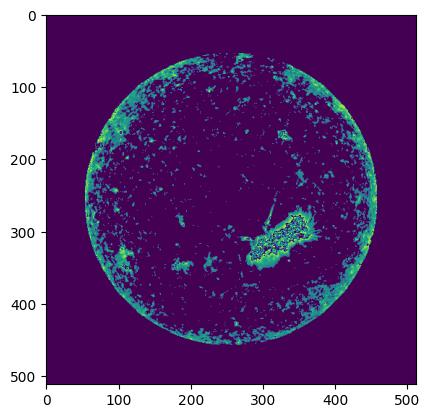

In [188]:
xi = norm(image_stack_t0[0][0].cpu().numpy())
xi[xi < 100] = 0
plt.imshow(xi)

In [153]:
# threshold to binary
thresh = cv2.threshold(norm(xi), 64, 256, cv2.THRESH_BINARY)[1]

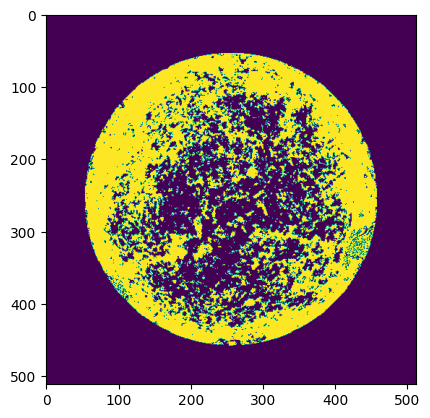

In [154]:
plt.imshow(thresh)

In [156]:
contours = cv2.findContours(norm(xi), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

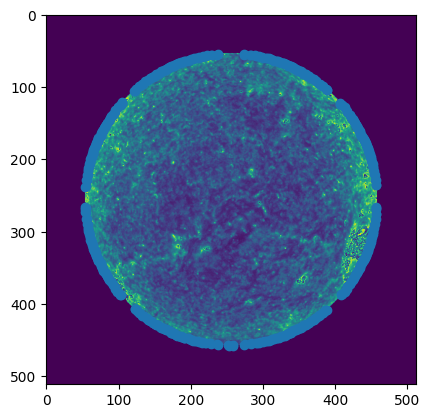

In [179]:
plt.imshow(norm(xi))
plt.scatter(contours[0][0][:, 0, 0], contours[0][0][:, 0, 1])

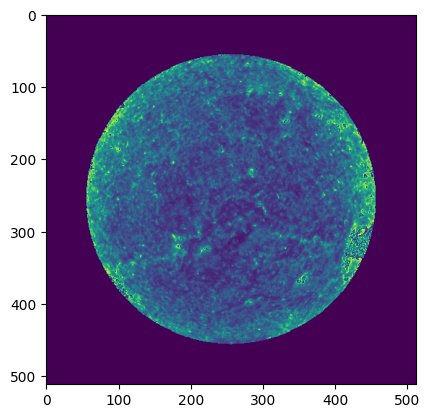

In [172]:
xc = cv2.drawContours(norm(xi), contours[0], 0, (0, 255, 255), 2)
plt.imshow(xc)

In [173]:
for x, y in contours[0][0][:, 0]:
    plt.scatter

array([[237,  54],
       [236,  55],
       [229,  55],
       ...,
       [282,  55],
       [274,  55],
       [273,  54]], dtype=int32)

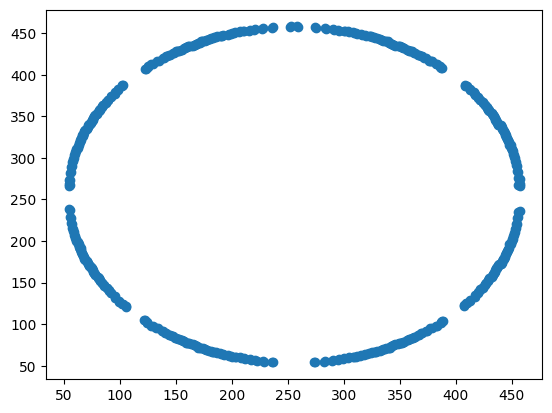

In [177]:
plt.scatter(contours[0][0][:, 0, 0], contours[0][0][:, 0, 1])